In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'NanumGothic'

In [6]:
!pip install finance-datareader

In [7]:
import FinanceDataReader as fdr

In [8]:
# 삼성전자(005930) 전체 (1996-11-05 ~ 현재)
samsung = fdr.DataReader('005930')

In [9]:
samsung.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2021-02-04,83500,83800,82100,82500,24171688,-0.024823
2021-02-05,83100,84000,82500,83500,18036835,0.012121
2021-02-08,83800,84200,83000,83000,15338765,-0.005988
2021-02-09,84000,84800,82700,82700,20898332,-0.003614
2021-02-10,82600,82600,81600,81600,22584721,-0.013301


In [10]:
# 주식데이터 가져오기
# 삼성전자 주식코드: 005930
STOCK_CODE = '005930'

In [11]:
stock = fdr.DataReader(STOCK_CODE)

In [12]:
stock.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
1997-02-27,1017,1031,999,1019,81090,NaN
1997-02-28,1019,1049,1001,1032,148450,0.012758
1997-03-03,1031,1042,1022,1025,73860,-0.006783
1997-03-04,1022,1024,988,1005,92870,-0.019512
1997-03-05,996,1004,971,978,153750,-0.026866


In [13]:
stock['Year'] = stock.index.year
stock['Month'] = stock.index.month
stock['Day'] = stock.index.day

In [14]:
stock.head()

,Open,High,Low,Close,Volume,Change,Year,Month,Day
Date,,,,,,,,,
1997-02-27,1017,1031,999,1019,81090,NaN,1997,2,27
1997-02-28,1019,1049,1001,1032,148450,0.012758,1997,2,28
1997-03-03,1031,1042,1022,1025,73860,-0.006783,1997,3,3
1997-03-04,1022,1024,988,1005,92870,-0.019512,1997,3,4
1997-03-05,996,1004,971,978,153750,-0.026866,1997,3,5


Text(0, 0.5, 'price')

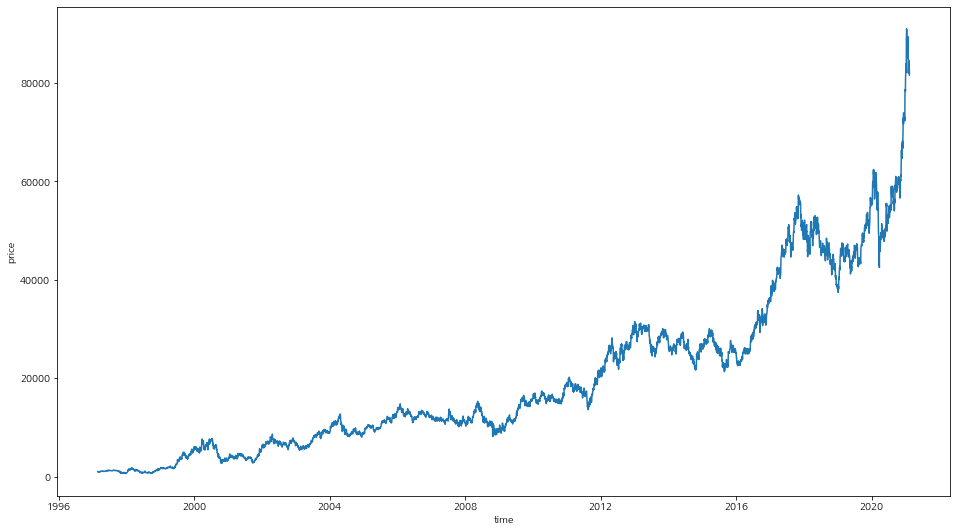

In [15]:
#시각화
plt.figure(figsize=(16, 9))
sns.lineplot(y=stock['Close'], x=stock.index)
plt.xlabel('time')
plt.ylabel('price')

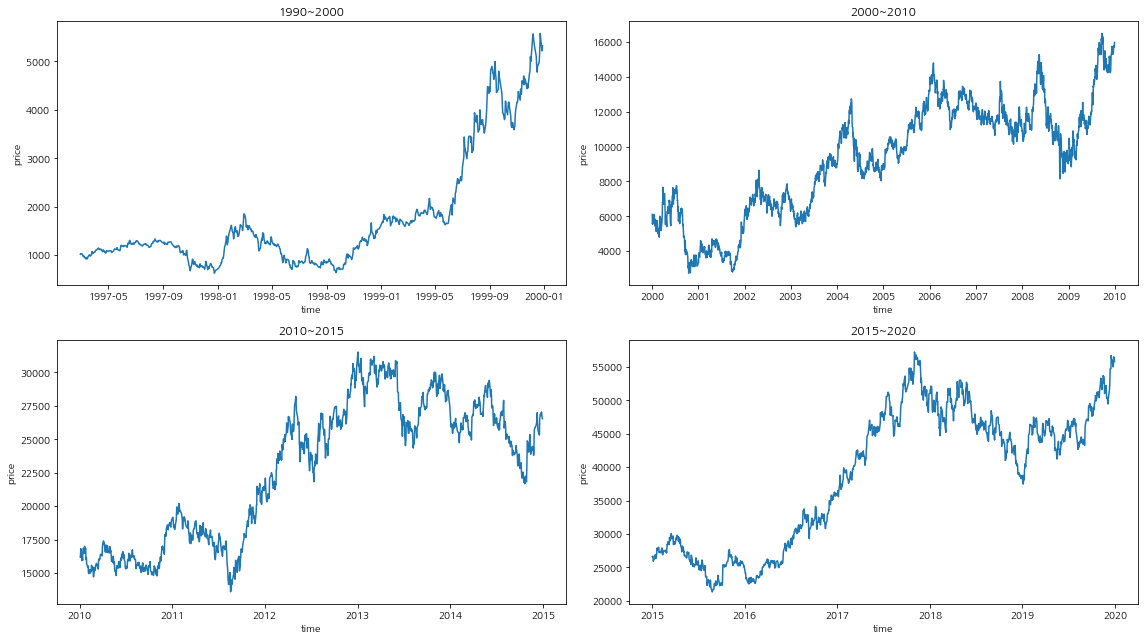

In [16]:
time_steps = [['1990', '2000'], 
              ['2000', '2010'], 
              ['2010', '2015'], 
              ['2015', '2020']]

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(16, 9)
for i in range(4):
    ax = axes[i//2, i%2]
    df = stock.loc[(stock.index > time_steps[i][0]) & (stock.index < time_steps[i][1])]
    sns.lineplot(y=df['Close'], x=df.index, ax=ax)
    ax.set_title(f'{time_steps[i][0]}~{time_steps[i][1]}')
    ax.set_xlabel('time')
    ax.set_ylabel('price')
plt.tight_layout()
plt.show()

In [17]:
#데이터 전처리
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
# 스케일 후 columns
scaled = scaler.fit_transform(stock[scale_cols])
scaled

array([[1.12624585e-02, 1.06508264e-02, 1.11620112e-02, 4.33757870e-03,
        8.97945220e-04],
       [1.12846069e-02, 1.08367769e-02, 1.11843575e-02, 4.48142697e-03,
        1.64385211e-03],
       [1.14174972e-02, 1.07644628e-02, 1.14189944e-02, 4.40397021e-03,
        8.17884252e-04],
       ...,
       [9.28017719e-01, 8.69834711e-01, 9.27374302e-01, 9.11477986e-01,
        1.69852888e-01],
       [9.30232558e-01, 8.76033058e-01, 9.24022346e-01, 9.08158410e-01,
        2.31416418e-01],
       [9.14728682e-01, 8.53305785e-01, 9.11731844e-01, 8.95986633e-01,
        2.50090545e-01]])

In [18]:
df = pd.DataFrame(scaled, columns=scale_cols)

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, random_state=0, shuffle=False)

In [21]:
x_train.shape, y_train.shape

((4800, 4), (4800,))

In [22]:
x_test.shape, y_test.shape

((1200, 4), (1200,))

In [23]:
x_train

,Open,High,Low,Volume
0,0.011262,0.010651,0.011162,0.000898
1,0.011285,0.010837,0.011184,0.001644
2,0.011417,0.010764,0.011419,0.000818
3,0.011318,0.010579,0.011039,0.001028
4,0.011030,0.010372,0.010849,0.001703
...,...,...,...,...
4795,0.283056,0.264050,0.282235,0.002495
4796,0.282171,0.264256,0.281117,0.002006
4797,0.280620,0.264256,0.282011,0.002246
4798,0.281063,0.264256,0.282011,0.002186


In [24]:
#TensorFlow Dataset을 활용한 시퀀스 데이터셋 구성
import tensorflow as tf

In [25]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [26]:
WINDOW_SIZE=20
BATCH_SIZE=32

In [27]:
# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full outp

In [28]:
# 아래의 코드로 데이터셋의 구성을 확인해 볼 수 있습니다.
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)
